# references
* http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html
* https://software.intel.com/en-us/articles/visualising-cnn-models-using-pytorch

In [24]:
%matplotlib inline

import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import random
import sys
import tqdm
import yaml

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from dataset import PartAffordanceDataset, ToTensor, CenterCrop, Normalize
from addict import Dict
from model import VGG16

In [25]:
CONFIG = Dict(yaml.safe_load(open('./result/config.yaml')))

In [26]:
data = PartAffordanceDataset(CONFIG.train_data,
                           config=CONFIG,
                           transform=transforms.Compose([
                               CenterCrop(CONFIG),
                               ToTensor(),
                               Normalize()
                           ]))

In [27]:
loader = DataLoader(data, batch_size=3, shuffle=True, num_workers=CONFIG.num_workers)

In [28]:
model = VGG16(CONFIG.in_channel, CONFIG.n_classes)
model.load_state_dict(torch.load('./result/best_accuracy_model.prm', map_location=lambda storage, loc: storage))
model.eval()

VGG16(
  (features): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Conv(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Conv(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv(
      (c

### numpy ベースでやる方法(for文回すから非効率)

In [29]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        # register a hook  to save features
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        # save features
        self.features = (output.to('cpu').data).numpy()
                        
    def remove(self):
        self.hook.remove()

In [30]:
final_layer = model._modules.get('features')[16]

In [31]:
activated_features = SaveFeatures(final_layer)

In [32]:
print(activated_features.features)

None


In [62]:
for sample in loader:
    img = sample['image']
    
    pred = model(img)
    
    print(activated_features.features.shape)
    print(pred.shape)
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    
    print(pred)
    
    break

(3, 512, 16, 16)
torch.Size([3, 7])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]], grad_fn=<IndexPutBackward>)


In [63]:
class_idx = np.where(pred==1)

In [64]:
class_idx

(array([0, 1, 2]), array([0, 0, 0]))

In [65]:
def getCAM(feature_conv, weight_fc, class_idx):
    '''
    feature_conv => output from the last conv layer
    weight_fc => the weight of fully connected layer
    class_idx => np.where(pred==1)    
    '''
    N, C, H, W = feature_conv.shape
    cam_img = []
    
    for n in range(N):
        index = np.where(class_idx[0]==n)   # indices of pred labels each image has
        cls = class_idx[1][index]            # decode one-hot vector, such as [0, 1, 3]
        
        for c in cls:
            cam = weight_fc[c].dot(feature_conv[n].reshape((C, H*W)))
            cam = cam.reshape(H, W)
            # Normalization
            cam = cam - np.min(cam)
            cam = cam / np.max(cam)
            cam_img.append(cam)
            
    return cam_img

In [66]:
weight_softmax_params = list(model._modules.get('classifier').parameters())

In [67]:
weight_softmax = np.squeeze(weight_softmax_params[0].to('cpu').data.numpy())

In [68]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

In [69]:
def reverse_normalize(x, mean=[0.2191, 0.2349, 0.3598], std=[0.1243, 0.1171, 0.0748]):
    x[0, :, :] = x[0, :, :] * std[0] + mean[0]
    x[1, :, :] = x[1, :, :] * std[1] + mean[1]
    x[2, :, :] = x[2, :, :] * std[2] + mean[2]
    return x

In [70]:
img_list = []
for c in class_idx[0]:
    i = reverse_normalize(img[c])
    i = i.numpy()
    img_list.append(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


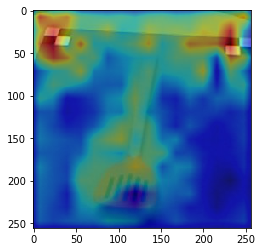

In [71]:
for i, o in zip(img_list, overlay):
    i = i.transpose((1, 2, 0))
    print(i.shape)
    imshow(i)
    imshow(skimage.transform.resize(o, i.shape[0:2]), alpha=0.5, cmap='jet')
    break

In [ ]:
### tensorベースでやる方法

In [8]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        # register a hook  to save features
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        # save features
        self.features = output.to('cpu').data
                        
    def remove(self):
        self.hook.remove()

In [9]:
final_layer = model._modules.get('features')[16]

In [10]:
activated_features = SaveFeatures(final_layer)

In [11]:
print(activated_features.features)

None


In [13]:
for sample in loader:
    img = sample['image']
    
    pred = model(img)
    
    print(activated_features.features.shape)
    print(pred.shape)
    pred[pred>0.5] = 1
    pred[pred<=0.5] = 0
    
    print(pred)
    
    break

torch.Size([3, 512, 16, 16])
torch.Size([3, 7])
tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]], grad_fn=<IndexPutBackward>)


In [14]:
params_fc = list(model._modules.get('classifier').parameters())
weight_fc = params_fc[0].to('cpu').data

In [15]:
weight_fc.shape

torch.Size([7, 512])

In [16]:
def getCAM(features, weight_fc):
    '''
    features: feature map before GAP.  shape => (N, C, H, W)
    weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
    cam: class activation map.  shape=> (N, num_classes, H, W)
    '''
    
    cam = F.conv2d(features, weight=weight_fc[:, :, None, None])
    
    return cam

In [18]:
a = getCAM(activated_features.features, weight_fc)

In [19]:
a.shape

torch.Size([3, 7, 16, 16])

In [20]:
pred

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]], grad_fn=<IndexPutBackward>)

In [21]:
# nonzero でインデックスの検索が可能
c = []
for i in pred.nonzero():
    print(i)
    print(a[i[0],i[1], :, :].shape)
    c.append(a[i[0],i[1], :, :].unsqueeze(0))
    
    # TODO: 正規化処理

tensor([0, 0])
torch.Size([16, 16])
tensor([1, 0])
torch.Size([16, 16])
tensor([2, 0])
torch.Size([16, 16])


In [23]:
def reverse_normalize(x, mean=[0.2191, 0.2349, 0.3598], std=[0.1243, 0.1171, 0.0748]):
    x[0, :, :] = x[0, :, :] * std[0] + mean[0]
    x[1, :, :] = x[1, :, :] * std[1] + mean[1]
    x[2, :, :] = x[2, :, :] * std[2] + mean[2]
    return x

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
img_list = []
for c in class_idx[0]:
    i = reverse_normalize(img[c])
    i = i.numpy()
    img_list.append(i)